# basic indicators

## APO
The Absolute Price Oscillator (APO) is based
on the absolute differences between two moving averages of different
lengths, a ‘Fast’ and a ‘Slow’ moving average.

APO = Fast Exponential Moving Average - Slow Exponential Moving Average

### import libs

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

### data

In [18]:
start_date = '2021-01-01'
end_date = '2022-01-01'

goog_data = yf.download('GOOG', start=start_date, end=end_date)
# goog_data = pd.DataFrame(index=goog_data.index)
goog_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,87.876999,88.032501,85.392502,86.412003,86.412003,38038000
2021-01-05,86.250000,87.383499,85.900749,87.045998,87.045998,22906000
2021-01-06,85.131500,87.400002,84.949997,86.764503,86.764503,52042000
2021-01-07,87.002998,89.419998,86.852501,89.362503,89.362503,45300000
2021-01-08,89.399002,90.491997,88.676750,90.360497,90.360497,41012000
...,...,...,...,...,...,...
2021-12-27,147.463501,148.426498,147.250000,148.063995,148.063995,13256000
2021-12-28,148.374496,148.374496,145.935501,146.447998,146.447998,18624000
2021-12-29,146.429504,147.183746,145.504501,146.504501,146.504501,17022000


In [19]:

close = goog_data['Adj Close']

num_periods_fast = 10 # time period for the fast EMA
K_fast = 2 / (num_periods_fast + 1) # smoothing factor for fast EMA
ema_fast = 0
num_periods_slow = 40 # time period for slow EMA
K_slow = 2 / (num_periods_slow + 1) # smoothing factor for slow EMA
ema_slow = 0

ema_fast_values = [] # we will hold fast EMA values for visualization purposes
ema_slow_values = [] # we will hold slow EMA values for visualization purposes
apo_values = [] # track computed absolute price oscillator values

for close_price in close:
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_fast + ema_fast
    ema_slow = (close_price - ema_slow) * K_slow + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)
  apo_values.append(ema_fast - ema_slow)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=goog_data.index))
goog_data = goog_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=goog_data.index))
goog_data = goog_data.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=goog_data.index))

close_price = goog_data['ClosePrice']
ema_f = goog_data['FastExponential10DayMovingAverage']
ema_s = goog_data['SlowExponential40DayMovingAverage']
apo = goog_data['AbsolutePriceOscillator']

### plot

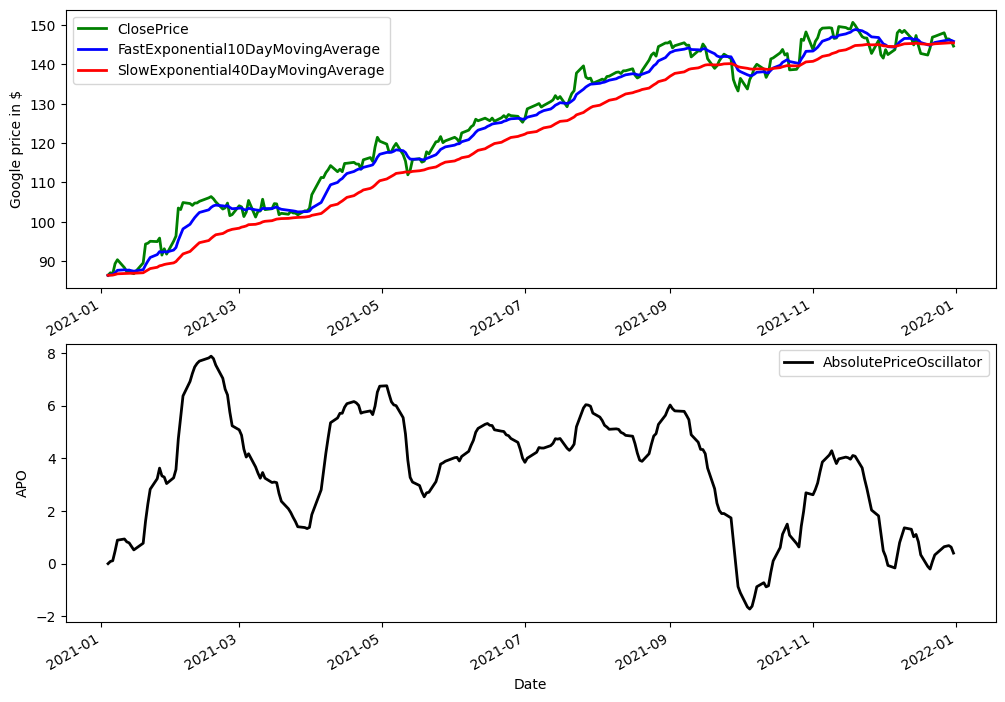

In [22]:
fig = plt.figure()
fig.set_size_inches(12, 9)
ax1 = fig.add_subplot(211, ylabel='Google price in $')
close_price.plot(ax=ax1, color='g', lw=2., legend=True)
ema_f.plot(ax=ax1, color='b', lw=2., legend=True)
ema_s.plot(ax=ax1, color='r', lw=2., legend=True)
ax2 = fig.add_subplot(212, ylabel='APO')
apo.plot(ax=ax2, color='black', lw=2., legend=True)
plt.show()

## BBAND

The Bollinger Band (BBANDS) study created
 by John Bollinger plots upper and lower envelope bands around the
 price of the instrument. The width of the bands is based on the
 standard deviation of the closing prices from a moving average of
 price.
 Middle
 Band = n-period moving average

Upper
 Band = Middle Band + ( y * n-period standard deviation)

Lower Band = Middle Band - ( y *
 n-period standard deviation)

Where:

n = number of periods
y = factor to apply to the standard deviation value, (typical default for y = 2)
Detailed:

Calculate the moving average.
 The formula is:
d = ((P1-MA)^2 + (P2-MA)^2 + ... (Pn-MA)^2)/n

Pn is the price you pay for the nth interval
n is the number of periods you select
Subtract the moving average
 from each of the individual data points used in the moving average
 calculation. This gives you a list of deviations from the average.
 Square each deviation and add them all together. Divide this sum
 by the number of periods you selected.

Take the square root of d. This gives you the standard deviation.

delta = sqrt(d)

Compute the bands by using the following formulas:
Upper Band = MA + delta
Middle Band = MA
Lower Band = MA - delta

In [24]:
import statistics as stats
import math as math

time_period = 20 # history length for Simple Moving Average for middle band
stdev_factor = 2 # Standard Deviation Scaling factor for the upper and lower bands
history = [] # price history for computing simple moving average
sma_values = [] # moving average of prices for visualization purposes
upper_band = [] # upper band values
lower_band = [] # lower band values

for close_price in close:
  history.append(close_price)
  if len(history) > time_period: # we only want to maintain at most 'time_period' number of price observations
    del (history[0])

  sma = stats.mean(history)
  sma_values.append(sma) # simple moving average or middle band
  variance = 0 # variance is the square of standard deviation
  for hist_price in history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(history)) # use square root to get standard deviation

  upper_band.append(sma + stdev_factor * stdev)
  lower_band.append(sma - stdev_factor * stdev)

goog_data = goog_data.assign(ClosePrice=pd.Series(close, index=goog_data.index))
goog_data = goog_data.assign(MiddleBollingerBand20DaySMA=pd.Series(sma_values, index=goog_data.index))
goog_data = goog_data.assign(UpperBollingerBand20DaySMA2StdevFactor=pd.Series(upper_band, index=goog_data.index))
goog_data = goog_data.assign(LowerBollingerBand20DaySMA2StdevFactor=pd.Series(lower_band, index=goog_data.index))

close_price = goog_data['ClosePrice']
mband = goog_data['MiddleBollingerBand20DaySMA']
uband = goog_data['UpperBollingerBand20DaySMA2StdevFactor']
lband = goog_data['LowerBollingerBand20DaySMA2StdevFactor']

### plot

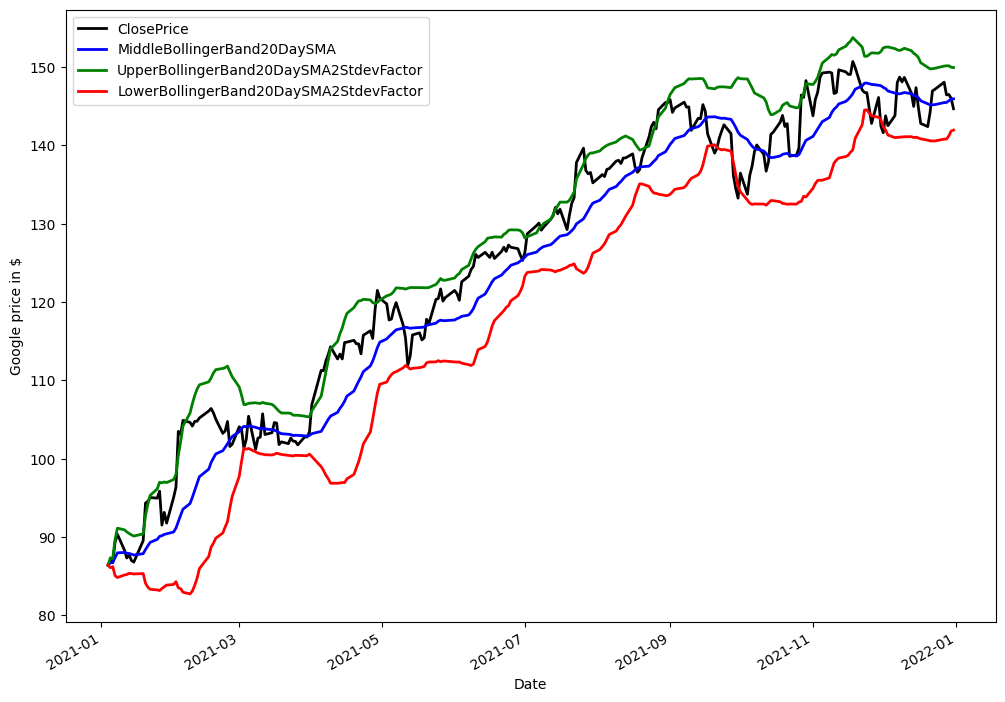

In [28]:
fig = plt.figure()
fig.set_size_inches(12, 9)
ax1 = fig.add_subplot(111, ylabel='Google price in $')
close_price.plot(ax=ax1, color='black', lw=2., legend=True)
mband.plot(ax=ax1, color='b', lw=2., legend=True)
uband.plot(ax=ax1, color='g', lw=2., legend=True)
lband.plot(ax=ax1, color='r', lw=2., legend=True)
plt.show()